**TODO**: sort through t_periastron and t0 reference epochs

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.3
pymc3 version: 3.5
exoplanet version: 0.1.7.dev0


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants
import astropy

# load the exoplanet part 
import pymc3 as pm 
import theano.tensor as tt

import corner

import exoplanet as xo
from exoplanet.distributions import Angle


deg = np.pi/180. # radians / degree
yr = 365.25 # days / year

au_to_R_sun = (constants.au / constants.R_sun).value # conversion constant

# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# for now, subtract from all dates for start of astrometric timeseries
jd0 = 2448630.485039346

In [11]:
def get_arrays(asciiTable, errDict=None, jitter=False):
    """
    Reformat ascii tables into pure numpy arrays of the right dimension.
    """
    
    output = []
    
    for star in ["Aa", "Ab"]:
    
        # get the RVs 
        rv = asciiTable["RV_" + star]
        
        if type(rv) is astropy.table.column.MaskedColumn:
            mask = ~rv.mask # values we want to keep when indexing
        else:
            mask = np.ones(len(rv), dtype="bool")

        rv = np.ascontiguousarray(rv[mask])
        date = np.ascontiguousarray(asciiTable["HJD"][mask]) + 2400000 - jd0
        
        if errDict is None:
            err = np.ascontiguousarray(asciiTable["sigma_" + star][mask])
        else:
            err = np.ones(len(date), dtype=np.float64) * errDict[star]
            
        if jitter:
            err = np.ones(len(date), dtype=np.float64) * 0.1 # [km/s] assume a small error, since we'll infer.

        assert len(date) == len(rv), "date - rv length mismatch"
        assert len(date) == len(err), "date - err length mismatch"
            
        tup = (date, rv, err)

        output.append(tup)

    return output
    
    
# Do this to infer w/ jitter 
jitter=True

# load all the data
data_cfa = ascii.read("../close/data/cfa.dat")
# cfa errors are provided in table 
cfa1,cfa2 = get_arrays(data_cfa, jitter=jitter)

data_keck = ascii.read("../close/data/keck.dat", format="tab", fill_values=[("X", 0)])
err_keck = {"Aa":0.63, "Ab":0.85, "B":0.59} # km/s
keck1,keck2 = get_arrays(data_keck, err_keck, jitter=jitter)

data_feros = ascii.read("../close/data/feros.dat")
err_feros = {"Aa":2.61, "Ab":3.59, "B":2.60} # km/s
feros1,feros2 = get_arrays(data_feros, err_feros, jitter=jitter)

data_dupont = ascii.read("../close/data/dupont.dat", fill_values=[("X", 0)])
err_dupont = {"Aa":1.46, "Ab":2.34, "B":3.95} # km/s
dupont1,dupont2 = get_arrays(data_dupont, err_dupont, jitter=jitter)

data = [data_cfa, data_keck, data_feros, data_dupont]


# specifically load the B velocities 
mask = ~data_keck["RV_B"].mask

keck3 = (np.ascontiguousarray(data_keck["HJD"][mask]) + 2400000 - jd0, 
         np.ascontiguousarray(data_keck["RV_B"][mask]), 0.2 * np.ones(np.sum(mask), dtype=np.float64))

In [14]:
# load the astrometric points for the close orbit 

# keep in mind that the primary and secondary stars *could* be switched
# separation is in milliarcseconds
int_data = ascii.read("../close/data/int_data.dat")

astro_jd = int_data["epoch"][0] - jd0
rho_data = int_data["sep"][0] * 1e-3 # arcsec
rho_err = int_data["sep_err"][0] * 1e-3 # arcsec 
theta_data = int_data["pa"][0] * deg # radians
theta_err = int_data["pa_err"][0] * deg # radians

anthonioz = (astro_jd, rho_data, rho_err, theta_data, theta_err)

In [16]:
# load the astrometry for the wide orbit

data = ascii.read("../wide/data/visual_data_besselian.csv", format="csv", fill_values=[("X", '0')])

# convert years 
jds = Time(np.ascontiguousarray(data["epoch"]), format="byear").jd - jd0

data["rho_err"][data["rho_err"].mask == True] = 0.05
data["PA_err"][data["PA_err"].mask == True] = 5.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns

rho_data = np.ascontiguousarray(data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(data["PA_err"] * deg) # radians

wds = (jds, rho_data, rho_err, theta_data, theta_err)

Hierarchical triple orbit simultaneously fit with RV and astrometry for both tight inner binary and wide outer binary: inner: `parallax`, `P_A`, `a_A_ang`, `M_Ab`, `e_A`, `i_A`, `omega_Aa`, `Omega_Aa`,  outer: `P_B`, `a_B_ang`, `e_AB`, `i_AB`, `omega_A`, `Omega_A`, `gamma_AB`. `M_A` is derived from inner orbit and fed to outer orbit.  `gamma_A` is essentially the RV prediction of A, and is derived from outer orbit and fed to the inner orbit. This has 15 orbital parameters. Adding 4 RV offsets, 2 * 4 RV jitter terms, and 2 astrometric jitter terms makes it 30 parameters total. 

The current red flag is that I'm getting different values of MA = MAa + MAb from the inner orbit and the outer orbit, which means that these parameters are not self-consistently determined.

In [18]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [19]:
52704.5 + 2400000 - jd0

4074.01496065408

In [69]:
zeros = np.zeros_like(wds[0])

xs_phase = np.linspace(0, 1, num=500)
t_data = np.linspace(-yr, wds[0][-1] + yr)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=27.31, sd=0.12) # milliarcsec GAIA DR2
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec

    a_ang_inner = pm.Uniform("a_ang_inner", 0.1, 10.0, testval=5.51) # milliarcsec 
        
    # the semi-major axis in au
    a_inner = pm.Deterministic("a_inner", 1e-3 * a_ang_inner / parallax) # au
    
    logP_inner = pm.Uniform("logP_inner", lower=0, upper=np.log(50.0),
                      testval=np.log(34.87846)) # days
    P_inner = pm.Deterministic("P_inner", tt.exp(logP_inner))
    
    e_inner = pm.Uniform("e_inner", lower=0, upper=1, testval=0.62)
    
    omega_inner = Angle("omega_inner", testval=80.5 * deg) # omega_Aa
    Omega_inner = Angle("Omega_inner", testval=110.0 * deg) 

    cos_incl_inner = pm.Uniform("cos_incl_inner", lower=-1.0, upper=1.0, 
                                testval=0.8) 
    incl_inner = pm.Deterministic("incl_inner", tt.arccos(cos_incl_inner))
    
    MAb = pm.Normal("MAb", mu=0.3, sd=0.5) # solar masses
    
    t_periastron_inner = pm.Uniform("t_peri_inner", lower=4020.0, upper=4070., 
                                    testval=4047.0) # + 2400000 + jd0

    orbit_inner = xo.orbits.KeplerianOrbit(a=a_inner*au_to_R_sun, period=P_inner, ecc=e_inner, 
                  t_periastron=t_periastron_inner, omega=omega_inner, Omega=Omega_inner, 
                                           incl=incl_inner, m_planet=MAb)

    # derived properties from inner orbit 
    MA = pm.Deterministic("MA", orbit_inner.m_total)
    MA_kep = pm.Deterministic("MA_kep", calc_Mtot(a_inner, P_inner))
    MAa = pm.Deterministic("MAa", MA - MAb)

    
    # define outer orbit stuff
    a_ang_outer = pm.Uniform("a_ang_outer", 0.1, 4.0, testval=1.8) # arcsec 
    
    # the semi-major axis in au
    a_outer = pm.Deterministic("a_outer", a_ang_outer / parallax) # au
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP_outer = pm.Normal("logP_outer", mu=np.log(500), sd=1.0)
    P_outer = pm.Deterministic("P_outer", tt.exp(logP_outer) * yr) # days
    
    omega_outer = Angle("omega_outer", testval=-80 * deg) # - pi to pi
    Omega_outer = Angle("Omega_outer", testval=2.1) # - pi to pi
      
    phi_outer = Angle("phi_outer", testval=1.1)
    
    n = 2*np.pi*tt.exp(-logP_outer) / yr
    
    t_periastron_outer = pm.Deterministic("t_peri_outer", (phi_outer + omega_outer) / n)
    
    cos_incl_outer = pm.Uniform("cos_incl_outer", lower=-1., upper=1.0, testval=np.cos(120.0 * deg))
    incl_outer = pm.Deterministic("incl_outer", tt.arccos(cos_incl_outer))
    e_outer = pm.Uniform("e_outer", lower=0.0, upper=1.0, testval=0.3)
    gamma_outer = pm.Uniform("gamma_outer", lower=0, upper=15, testval=9.0) # km/s on CfA RV scale

    
    Mtot = pm.Deterministic("Mtot", calc_Mtot(a_outer, P_outer))

    MB = pm.Deterministic("MB", Mtot - MA) # solar masses

    # prevent things from blowing up on MB
    pm.Potential("MB_prior", -0.5*(MB - 0.5)**2/(0.5)**2)

    orbit_outer = xo.orbits.KeplerianOrbit(a=a_outer*au_to_R_sun, period=P_outer, ecc=e_outer, 
            t_periastron=t_periastron_outer, omega=omega_outer, Omega=Omega_outer, 
                                     incl=incl_outer, m_planet=MB)
    
    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot_orbit = pm.Deterministic("Mtot_orbit", orbit_outer.m_total)
    
    # MA derived from outer orbit. Hopefully consistent with derivation from inner orbit.
    MA_outer = pm.Deterministic("MA_outer", Mtot_orbit - MB) 
    

    # parameters to shift the RV scale onto the CfA scale
    offset_keck = pm.Normal("offsetKeck", mu=0.0, sd=5.0) # km/s
    offset_feros = pm.Normal("offsetFeros", mu=0.0, sd=5.0) # km/s
    offset_dupont = pm.Normal("offsetDupont", mu=0.0, sd=5.0) # km/s

    
    def get_gamma_A(t):
        """
        Helper function to determine gamma of the inner orbit.
        
        Args:
            t: time to query
            
        Returns:
            gamma_A (t) : [km/s]
        """
    
        gamma_A = conv * orbit_outer.get_star_velocity(t)[2]

        return gamma_A
    

    # get the radial velocity predictions for RV B 
    rv3_keck = conv * orbit_outer.get_planet_velocity(keck3[0])[2] + gamma_outer + offset_keck

    # since we have 4 instruments, we need to predict 4 different dataseries
    def get_RVs(t1, t2, offset):
        """
        Helper function for RVs. 

        Args:
            t1: times to query for star 1
            t2 : times to query for star 2
            offset: (km/s)
            
        Returns:
            (rv1, rv2) [km/s] evaluated at those times with offset applied
       """
        # get the RV predictions
        # get_star_velocity and get_planet_velocity return (v_x, v_y, v_z) tuples, 
        # so we only need the v_z vector
        # but, note that since +Z points towards the observer, 
        # we actually want v_radial = -v_Z (see conv)
        rv1 = conv * orbit_inner.get_star_velocity(t1)[2] + get_gamma_A(t1) + offset
        rv2 = conv * orbit_inner.get_planet_velocity(t2)[2] + get_gamma_A(t2) + offset
        
        return (rv1, rv2)
    

    # expects m/s
    # dates are the first entry in each tuple of (date, rv, err)
    rv1_cfa, rv2_cfa = get_RVs(cfa1[0], cfa2[0], 0.0)
    rv1_keck, rv2_keck = get_RVs(keck1[0], keck2[0], offset_keck)
    rv1_feros, rv2_feros = get_RVs(feros1[0], feros2[0], offset_feros)
    rv1_dupont, rv2_dupont = get_RVs(dupont1[0], dupont2[0], offset_dupont)
    
    logjit_cfa = pm.Uniform("logjittercfa", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_keck = pm.Uniform("logjitterkeck", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_feros = pm.Uniform("logjitterferos", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_dupont = pm.Uniform("logjitterdupont", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    jit_cfa = pm.Deterministic("jitCfa", tt.exp(logjit_cfa))
    jit_keck = pm.Deterministic("jitKeck", tt.exp(logjit_keck))
    jit_feros = pm.Deterministic("jitFeros", tt.exp(logjit_feros))
    jit_dupont = pm.Deterministic("jitDupont", tt.exp(logjit_dupont))
    
    # get the total errors
    def get_err(rv_err, logjitter):
        return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))
    
    # define the RV likelihoods
    pm.Normal("cfaRV1Obs", mu=rv1_cfa, observed=cfa1[1], sd=get_err(cfa1[2], logjit_cfa))
    pm.Normal("cfaRV2Obs", mu=rv2_cfa, observed=cfa2[1], sd=get_err(cfa2[2], logjit_cfa))
    
    pm.Normal("keckRV1Obs", mu=rv1_keck, observed=keck1[1], sd=get_err(keck1[2], logjit_keck))
    pm.Normal("keckRV2Obs", mu=rv2_keck, observed=keck2[1], sd=get_err(keck2[2], logjit_keck))
    pm.Normal("keckRV3Obs", mu=rv3_keck, observed=keck3[1], sd=get_err(keck3[2], logjit_keck))
    
    pm.Normal("ferosRV1Obs", mu=rv1_feros, observed=feros1[1], sd=get_err(feros1[2], logjit_feros))
    pm.Normal("ferosRV2Obs", mu=rv2_feros, observed=feros2[1], sd=get_err(feros2[2], logjit_feros))
    
    pm.Normal("dupontRV1Obs", mu=rv1_dupont, observed=dupont1[1], sd=get_err(dupont1[2], logjit_dupont))
    pm.Normal("dupontRV2Obs", mu=rv2_dupont, observed=dupont2[1], sd=get_err(dupont2[2], logjit_dupont))
    
    
    # RV predictions
    t_dense_RV = xs_phase * P_inner + t_periastron_inner

    rv1, rv2 = get_RVs(t_dense_RV, t_dense_RV, 0.0)
    
    rv1_dense = pm.Deterministic("RV1Dense", rv1)
    rv2_dense = pm.Deterministic("RV2Dense", rv2)
    
    # get the astrometric predictions    
    # since there is only one Anthonioz measurement, we won't use jitter 
    rho_inner, theta_inner = orbit_inner.get_relative_angles(anthonioz[0], parallax) # arcsec

    # astrometric likelihood functions
    pm.Normal("obs_rho_inner", mu=rho_inner, observed=anthonioz[1], sd=anthonioz[2])
    # wrap-safe
    theta_diff_inner = tt.arctan2(tt.sin(theta_inner - anthonioz[3]), tt.cos(theta_inner - anthonioz[3])) 
    pm.Normal("obs_theta_inner", mu=theta_diff_inner, observed=0.0, sd=anthonioz[4])

    rho_outer, theta_outer = orbit_outer.get_relative_angles(wds[0], parallax) # arcsec

    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(wds[2])), sd=2.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(wds[4])), sd=2.0)
    
    rho_tot_err = tt.sqrt(wds[2]**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(wds[4]**2 + tt.exp(2*log_theta_s))
    
    pm.Normal("obs_rho_outer", mu=rho_outer, observed=wds[1], sd=rho_tot_err)
    theta_diff_outer = tt.arctan2(tt.sin(theta_outer - wds[3]), tt.cos(theta_outer - wds[3]))
    pm.Normal("obs_theta_outer", mu=theta_diff_outer, observed=zeros, sd=theta_tot_err)
    
    # save some samples on a fine orbit for plotting purposes
    t_period = pm.Deterministic("tPeriod", xs_phase * P_outer)
    
    rho, theta = orbit_outer.get_relative_angles(t_period, parallax)
    rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
    theta_save_sky = pm.Deterministic("thetaSaveSky", theta)
    
    rho, theta = orbit_outer.get_relative_angles(t_data, parallax)
    rho_save_data = pm.Deterministic("rhoSaveData", rho)
    theta_save_data = pm.Deterministic("thetaSaveData", theta)

In [70]:
with model:
    map_sol0 = xo.optimize(vars=[t_periastron_inner, gamma_outer])
    map_sol1 = xo.optimize(map_sol0, vars=[a_ang_inner, logP_inner, omega_inner, Omega_inner, 
                                           cos_incl_inner, e_inner, gamma_outer])
    map_sol2 = xo.optimize(map_sol1, vars=[phi_outer, omega_outer, 
                                            Omega_outer, cos_incl_outer, e_outer])
    map_sol3 = xo.optimize(map_sol2)

optimizing logp for variables: ['gamma_outer_interval__', 't_peri_inner_interval__']
message: Optimization terminated successfully.
logp: -136204.1573217349 -> -99952.62683717601
optimizing logp for variables: ['gamma_outer_interval__', 'e_inner_interval__', 'cos_incl_inner_interval__', 'Omega_inner_angle__', 'omega_inner_angle__', 'logP_inner_interval__', 'a_ang_inner_interval__']
message: Desired error not necessarily achieved due to precision loss.
logp: -99952.62683717601 -> -98460.73837098562
optimizing logp for variables: ['e_outer_interval__', 'cos_incl_outer_interval__', 'Omega_outer_angle__', 'omega_outer_angle__', 'phi_outer_angle__']
message: Optimization terminated successfully.
logp: -98460.73837098562 -> -4422.778743088302
optimizing logp for variables: ['logThetaS', 'logRhoS', 'logjitterdupont_interval__', 'logjitterferos_interval__', 'logjitterkeck_interval__', 'logjittercfa_interval__', 'offsetDupont', 'offsetFeros', 'offsetKeck', 'gamma_outer_interval__', 'e_outer_int

In [79]:
map_sol2

{'mparallax': array(27.31),
 'a_ang_inner_interval__': array(-0.05438705),
 'logP_inner_interval__': array(2.28850699),
 'e_inner_interval__': array(0.54587869),
 'omega_inner_angle__': array([4.39952063, 0.80263165]),
 'Omega_inner_angle__': array([ 4.24990963, -1.39221692]),
 'cos_incl_inner_interval__': array(1.77416313),
 'MAb': array(0.3),
 't_peri_inner_interval__': array(-0.48410405),
 'a_ang_outer_interval__': array(-0.25782911),
 'logP_outer': array(6.2146081),
 'omega_outer_angle__': array([-3.73522254,  2.45929091]),
 'Omega_outer_angle__': array([2.39941472, 3.77396449]),
 'phi_outer_angle__': array([2.18012164, 3.90474961]),
 'cos_incl_outer_interval__': array(-0.27779042),
 'e_outer_interval__': array(-1.09063211),
 'gamma_outer_interval__': array(0.46933925),
 'offsetKeck': array(0.),
 'offsetFeros': array(0.),
 'offsetDupont': array(0.),
 'logjittercfa_interval__': array(0.77540547),
 'logjitterkeck_interval__': array(0.77540547),
 'logjitterferos_interval__': array(0.7

In [68]:
for var in ["MAb", "MA", "MA_kep", "MA_outer", "MAa", "MB", "Mtot", "Mtot_orbit"]:
    print(var, map_sol3[var])

MAb 0.33389460480531724
MA 0.7328929810430284
MA_kep 0.7328929810430288
MA_outer 0.7328929810430189
MAa 0.3989983762377111
MB 14.429776787394129
Mtot 15.162669768437157
Mtot_orbit 15.162669768437148


I think the problem is that Mtot is determined from a, P. And so, if M2 is above that implied value, there is no error to say that we're using a negative mass.

Maybe a way forward:

* specify `MAb`, `a_inner`, `P_inner` -> implies `MA`
* specify `a_outer`, `P_outer` -> implies Mtot
* `MB = Mtot - MA`

Now, let's make some diagnostic plots of what's going on.

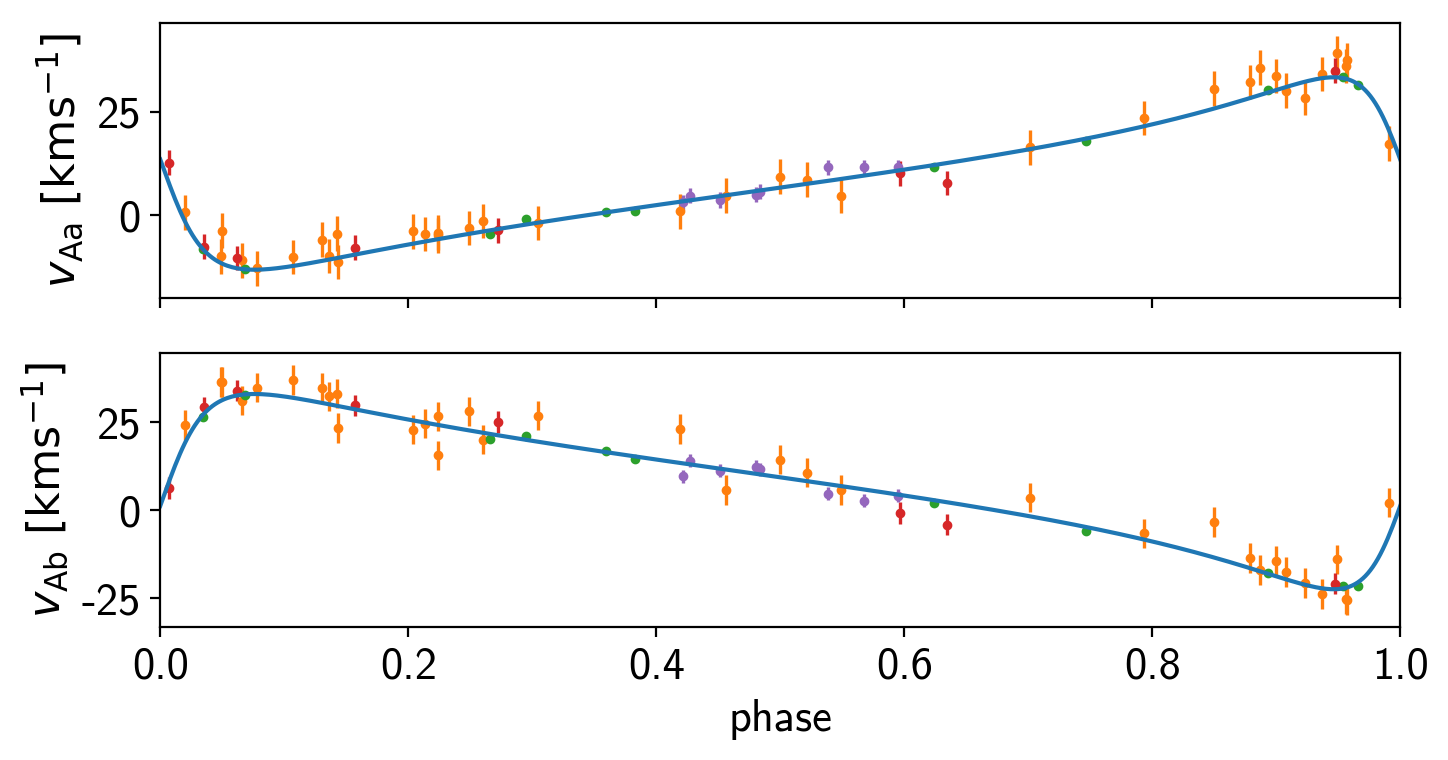

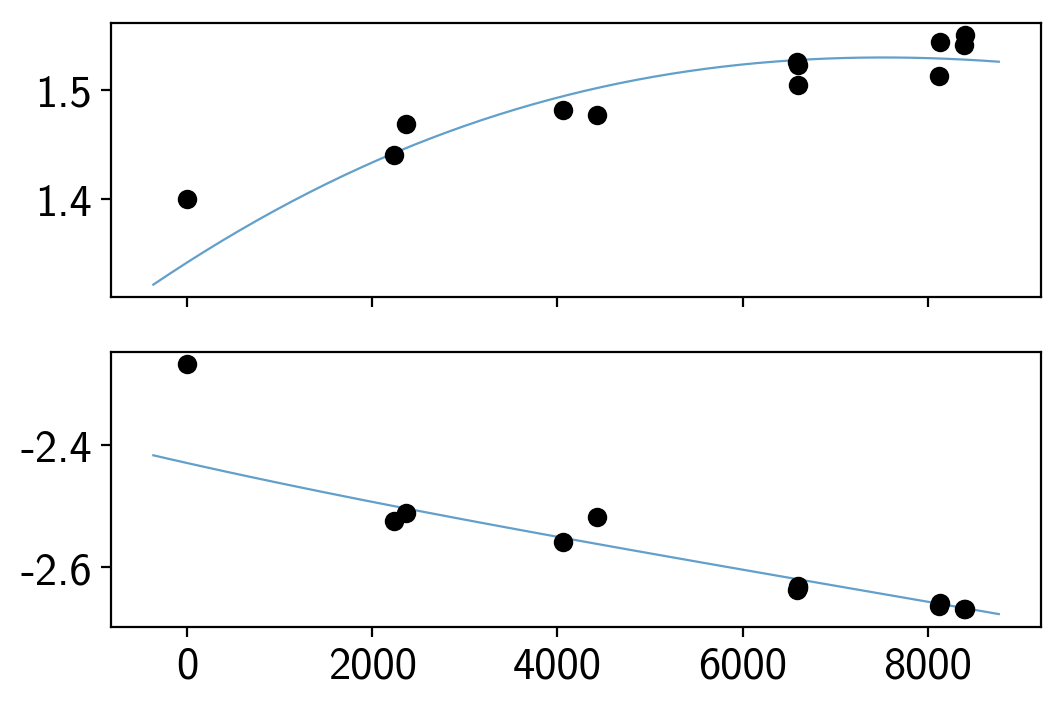

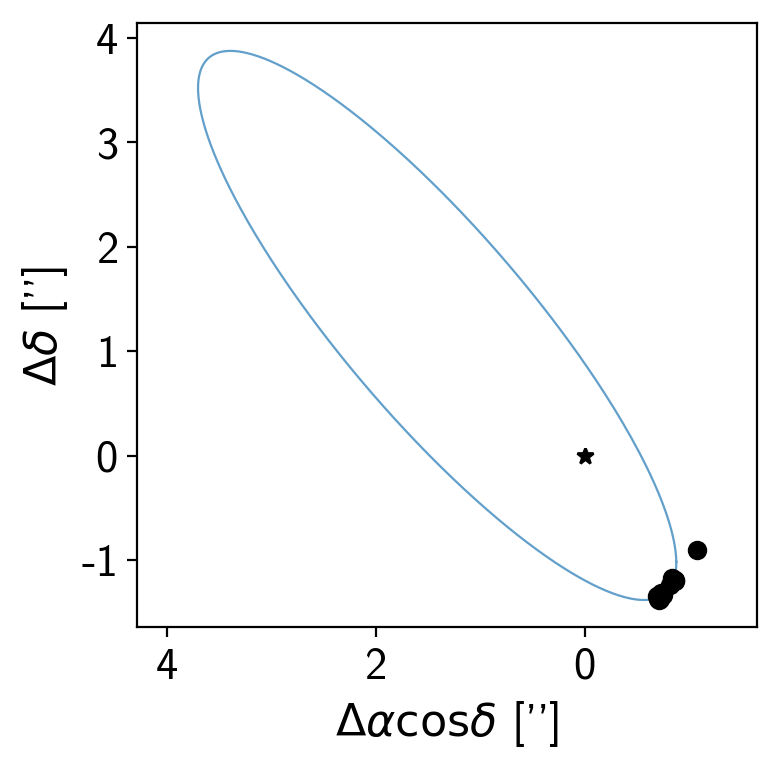

In [72]:
# phase inner orbit

# plot everything ontop in a single plot

pkw = {"marker":".", "ls":""}
ekw = {"marker":".", "ms":5.0, "ls":"", "elinewidth":1.2}

def get_phase(dates, pos):
    return ((dates - pos["t_peri_inner"]) % pos["P_inner"]) / pos["P_inner"]

# nsamples = 10
# choices = np.random.choice(np.arange(len(trace)), size=nsamples)

# just choose one representative sample
np.random.seed(43)
# choice = np.random.choice(np.arange(len(trace)))

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,4))

fig_sep, ax_sep = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))


with model:
    
    pos = map_sol3

    t_peri_inner = pos["t_peri_inner"]
    P_inner = pos["P_inner"]

    # calculate the errors for each instrument
    cfa_err1 = np.sqrt(cfa1[2]**2 + np.exp(2 * pos["logjittercfa"]))
    cfa_err2 = np.sqrt(cfa2[2]**2 + np.exp(2 * pos["logjittercfa"]))
    
    keck_err1 = np.sqrt(keck1[2]**2 + np.exp(2 * pos["logjitterkeck"]))
    keck_err2 = np.sqrt(keck2[2]**2 + np.exp(2 * pos["logjitterkeck"]))
    
    feros_err1 = np.sqrt(feros1[2]**2 + np.exp(2 * pos["logjitterferos"]))
    feros_err2 = np.sqrt(feros2[2]**2 + np.exp(2 * pos["logjitterferos"]))
    
    dupont_err1 = np.sqrt(dupont1[2]**2 + np.exp(2 * pos["logjitterdupont"]))
    dupont_err2 = np.sqrt(dupont2[2]**2 + np.exp(2 * pos["logjitterdupont"]))
    
    
    ax[0].plot(xs_phase, pos["RV1Dense"])
    ax[1].plot(xs_phase, pos["RV2Dense"])
    
    # at data locations
    ax[0].errorbar(get_phase(cfa1[0], pos), cfa1[1], yerr=cfa_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(keck1[0], pos), keck1[1] - pos["offsetKeck"], yerr=keck_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(feros1[0], pos), feros1[1] - pos["offsetFeros"], yerr=feros_err1, **ekw, zorder=0)
    ax[0].errorbar(get_phase(dupont1[0], pos), dupont1[1] - pos["offsetDupont"], yerr=dupont_err1, **ekw, zorder=0)
    
    # at data locations
    ax[1].errorbar(get_phase(cfa2[0], pos), cfa2[1], yerr=cfa_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(keck2[0], pos), keck2[1] - pos["offsetKeck"], yerr=keck_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(feros2[0], pos), feros2[1] - pos["offsetFeros"], yerr=feros_err2, **ekw, zorder=0)
    ax[1].errorbar(get_phase(dupont2[0], pos), dupont2[1] - pos["offsetDupont"], yerr=dupont_err2, **ekw, zorder=0)

    ax[1].set_xlim(0.0, 1.0)
    ax[0].set_ylabel(r"$v_\mathrm{Aa}$ $[\mathrm{km s}^{-1}]$")
    ax[1].set_ylabel(r"$v_\mathrm{Ab}$ $[\mathrm{km s}^{-1}]$")
    ax[1].set_xlabel("phase")
    
    
    t_pred = pos["tPeriod"]
    rho_pred = pos["rhoSaveSky"]
    theta_pred = pos["thetaSaveSky"]

    x_pred = rho_pred * np.cos(theta_pred) # X north
    y_pred = rho_pred * np.sin(theta_pred) # Y east

    ax_sep[0].plot(t_data, pos["rhoSaveData"], lw=0.8, alpha=0.7, zorder=0)
    ax_sep[0].plot(wds[0], wds[1], "ko")
    ax_sep[1].plot(t_data, pos["thetaSaveData"], lw=0.8, alpha=0.7, zorder=0)
    ax_sep[1].plot(wds[0], wds[3], "ko")

    ax_sky.plot(y_pred, x_pred, lw=0.8, alpha=0.7)
    
    
xs = wds[1] * np.cos(wds[3]) # X is north
ys = wds[1] * np.sin(wds[3]) # Y is east

ax_sky.plot(ys, xs, "ko")
ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax_sky.invert_xaxis()
ax_sky.plot(0,0, "k*")
ax_sky.set_aspect("equal", "datalim")

# fig.subplots_adjust(top=0.98, bottom=0.18, hspace=0.05)
# fig.savefig("A_sb_orbit.pdf")

In [80]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(finish=400, chains=4)
with model:
    burnin = sampler.tune(tune=2000, start=map_sol2, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

Sampling 4 chains: 100%|██████████| 1608/1608 [02:05<00:00,  3.99draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logThetaS, logRhoS, logjitterdupont, logjitterferos, logjitterkeck, logjittercfa, offsetDupont, offsetFeros, offsetKeck, gamma_outer, e_outer, cos_incl_outer, phi_outer, Omega_outer, omega_outer, logP_outer, a_ang_outer, t_peri_inner, MAb, cos_incl_inner, Omega_inner, omega_inner, e_inner, logP_inner, a_ang_inner, mparallax]
Sampling 4 chains: 100%|██████████| 8000/8000 [13:16<00:00,  5.98draws/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [81]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mparallax,27.324568,0.118102,1.275611e-03,27.096193,27.553647,11154.341334,1.000066
MAb,0.151570,0.053300,1.060041e-03,0.093249,0.262807,2075.243264,1.000859
logP_outer,6.705483,0.158764,2.942491e-03,6.374445,6.959075,3247.265342,1.000222
offsetKeck,1.066104,0.520697,6.192701e-03,0.083170,2.113958,7209.031197,0.999976
offsetFeros,3.323637,0.991635,9.702521e-03,1.452097,5.331122,8188.969622,0.999786
offsetDupont,2.058855,0.720517,8.016153e-03,0.653380,3.467620,7265.680033,0.999896
logRhoS,-3.940900,0.317989,3.567800e-03,-4.555449,-3.329851,7190.678739,0.999764
logThetaS,-3.781872,0.310508,3.591862e-03,-4.348773,-3.167722,7699.287746,0.999827
parallax,0.027325,0.000118,1.275611e-06,0.027096,0.027554,11154.341334,1.000066
a_ang_inner,3.908168,0.416589,7.917807e-03,3.404039,4.768596,2290.976736,1.000516


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c871cc048>,
      dtype=object)

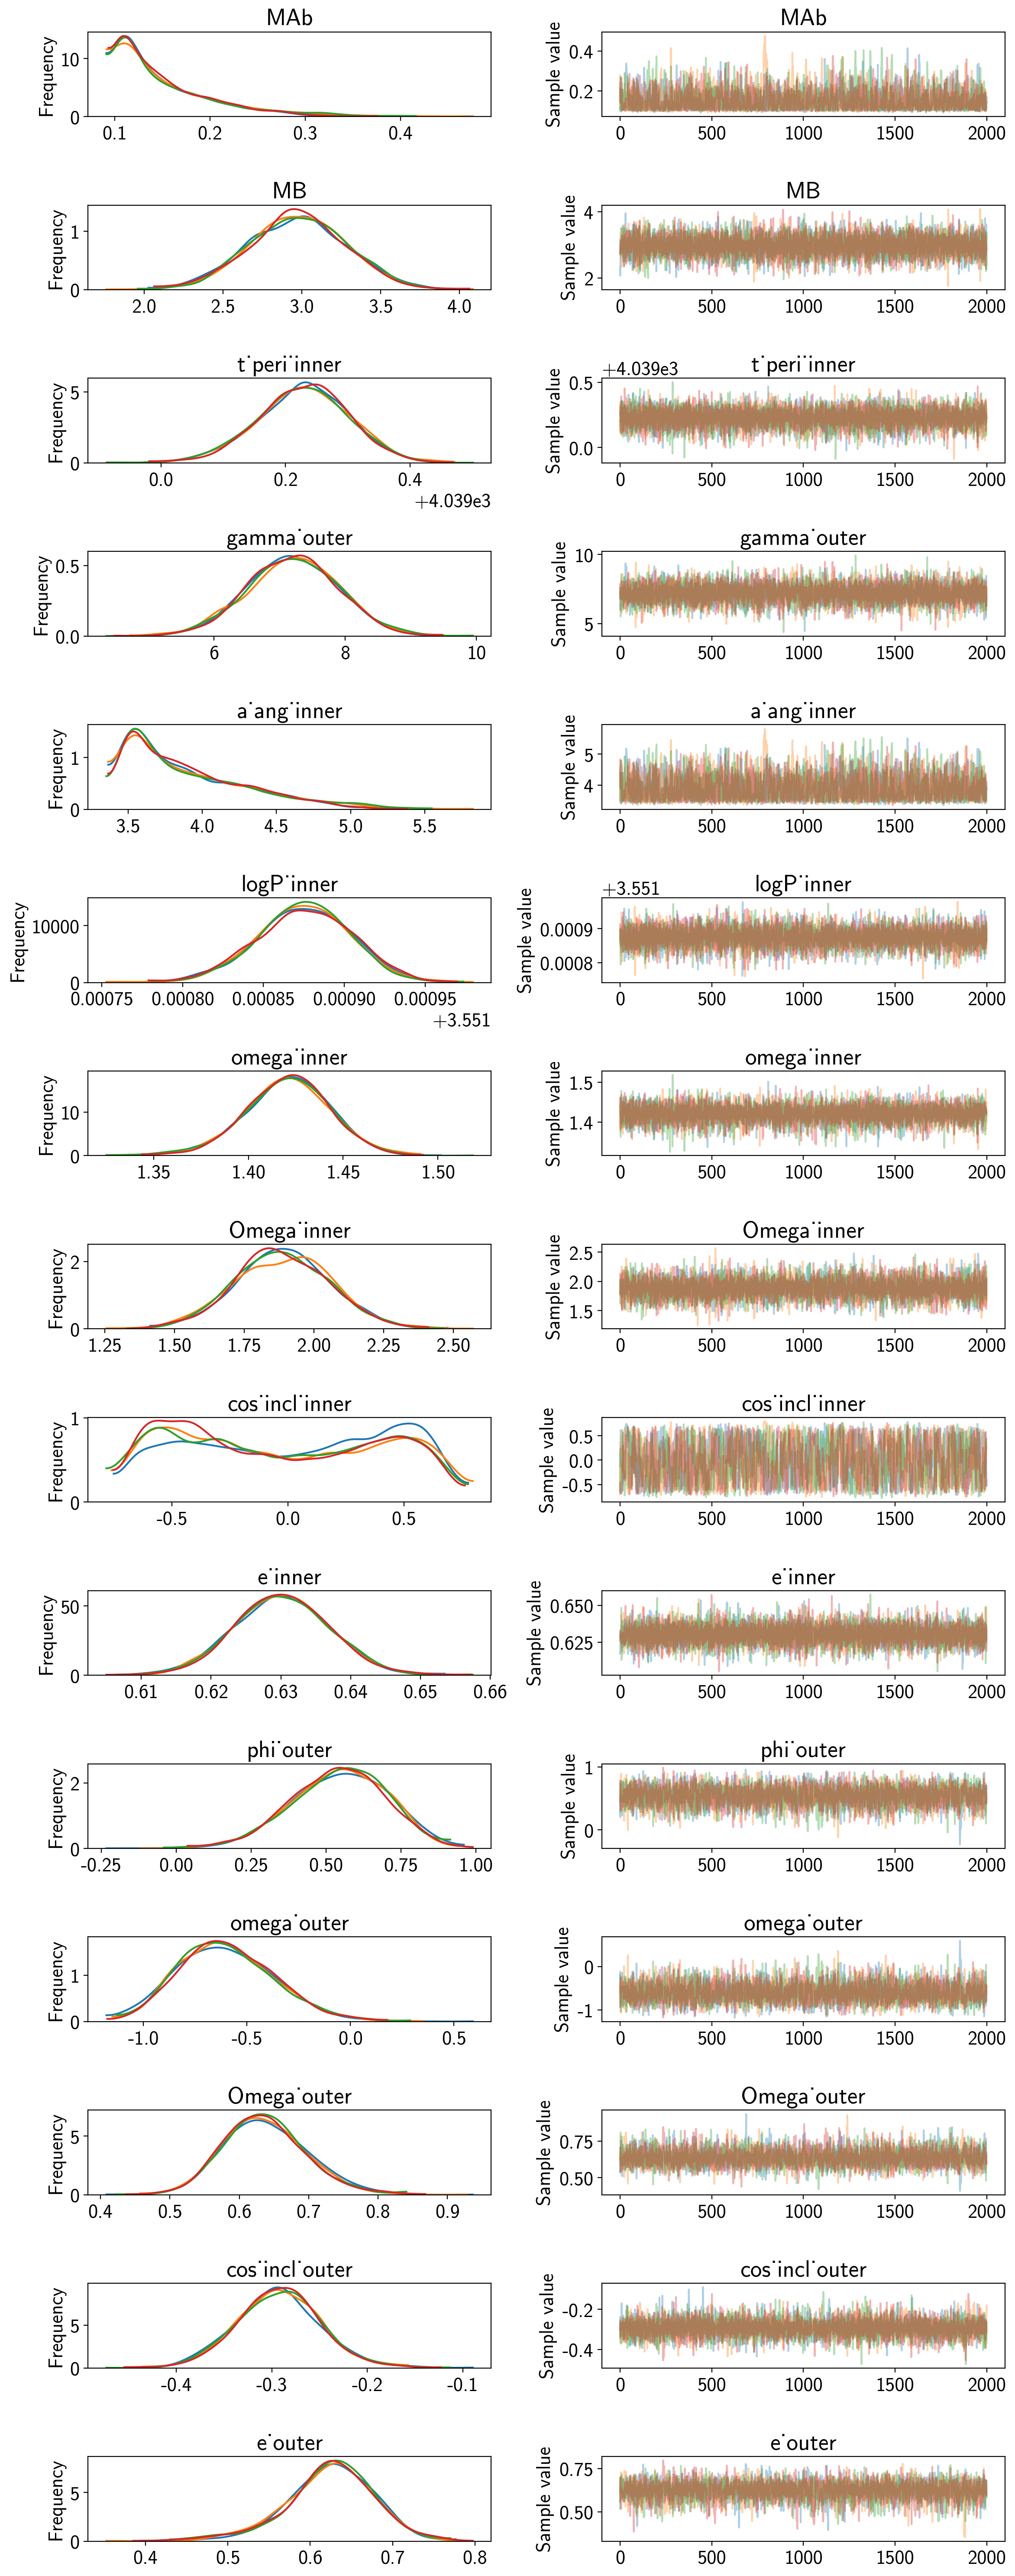

In [82]:
vars = ["MAb", "MB", "t_peri_inner", "gamma_outer", "a_ang_inner", "logP_inner", "omega_inner", "Omega_inner", 
    "cos_incl_inner", "e_inner", "phi_outer", "omega_outer", "Omega_outer", "cos_incl_outer", "e_outer"]
pm.traceplot(trace, varnames=vars)

In [83]:
pm.backends.ndarray.save_trace(trace, directory="current", overwrite=True)

'current'